# Exponential Growth and Decline Models

Accurate prediction of exponential growth and decline can be accomplished by fitting the data into several well-established models.

## Exponential Growth and Decline

In the most general form, the exponential growth function is defined by the following equation:

$$f(x) = ab^x$$


The model is defined by three key parameters: `a`, which represents the starting value; `b`, the growth rate; and `x`, symbolizing time. The behavior of the model is heavily influenced by the value of `b`. Specifically, when `b` is less than 1, the starting value progressively decreases towards 0. Conversely, if `b` is greater than 1, the starting value amplifies, growing towards infinity. At each step in the process, the previous value is either increased or decreased by a factor of `b`.

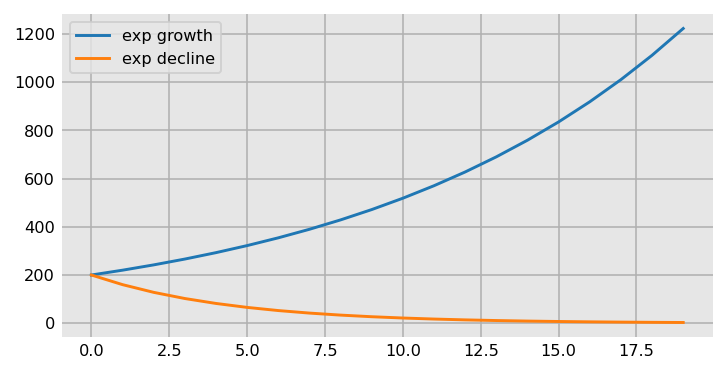

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dashboard.mplstyle')

a = 200
x = np.arange(20)

# growth at 10% each day
y_inc = a * 1.1 ** x
# decline at 20% each day
y_dec = a * 0.8 ** x

fig, ax = plt.subplots()
ax.plot(y_inc, label='exp growth')
ax.plot(y_dec, label='exp decline')
ax.legend();

## Modeling Total Cases with Scipy's `least_squares`

The `least_square` method is used to find the best fitting line/curved for regression analysis. The best fitting line is found by minimizing the sum of the squares (`the difference between the values observed and the values predicted by the model`). 


In [35]:
from prepare import PrepareData
data = PrepareData(download_new=False).run()
usa_cases = data['usa_cases']
usa_cases = usa_cases.loc[:'2020-09-01']
californiac = usa_cases['California']
californiac = californiac[californiac > 0]
californiac.head()

2020-01-26    2
2020-01-27    2
2020-01-28    2
2020-01-29    2
2020-01-30    2
Name: California, dtype: int64

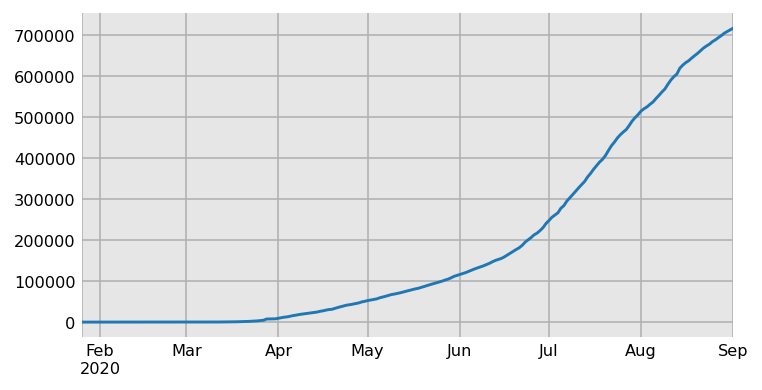

In [36]:
californiac.plot();

## Exponential Growth 

In [37]:

def simple_exp(x, a, b):
    """
    Simple exponential model
    
    Parameters
    ----------
    x : array of x-values, usually just np.arange(len(y))
    
    a : initial starting value
    
    b : growth rate
    
    Returns
    -------
    Evaluated function values as an array
    """
    return a * b ** x

The `least_square` function from scipy's `optimize` module will help find optimal values for `a` and `b`. 

In [38]:
def optimize_func(params, x, y, model):
    """
    Function to be passed as first argument to least_squares

    Parameters
    ----------
    params : sequence of parameter values for model

    x : x-values from data

    y : y-values from data

    model : function to be evaluated at x with params

    Returns
    -------
    Error between function and actual data
    """
    y_pred = model(x, *params)
    error = y - y_pred
    return error

The `least_squares` function is structured as follows:

```python
least_squares(optimize_func, initial_guess, args=(x, y, model))
```

This function requires an initial estimate for `x0`. The purpose of this initial guess is to aid in identifying parameter values that effectively minimize the total squared error. The `args` keyword parameter enables the passing of `x`, `y`, and `model` as a tuple.

For the parameters `a` and `b`, an initial guess of 1 is chosen. This serves as an optimal starting point since `a` is required to be positive, and `b` must exceed 1. The parameter values are further refined by setting bounds as a two-item tuple, representing the lower and upper limits. Specifically, `a` is bounded between 1 and infinity, while `b` is constrained within the range of 1 to 10.

The output of the `least_squares` function is an object encompassing detailed information regarding the optimization process. This information is subsequently assigned to the variable `res`, facilitating further analysis and application.


In [39]:
from scipy.optimize import least_squares
y = californiac.values
x = np.arange(len(y))
lower_bounds = 1, 1
upper_bounds = np.inf, 10
bounds = lower_bounds, upper_bounds
p0 = 1, 1
res = least_squares(optimize_func, p0, args=(x, y, simple_exp), bounds=bounds)

The optimal values of the parameters are found in the `x` attribute.

In [40]:
res.x

array([1.08300114e+04, 1.02005983e+00])

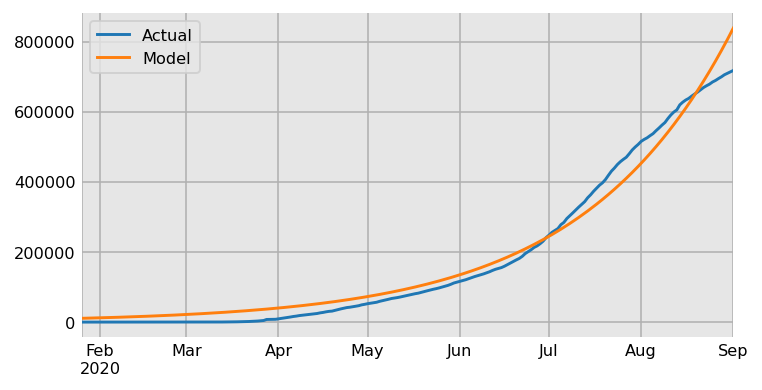

In [41]:
y_pred = simple_exp(x, *res.x)
s_pred = pd.Series(data=y_pred, index=californiac.index)
californiac.plot(label="Actual")
s_pred.plot(label="Model").legend();


### Predicting unseen data
The model closely resembles the data, but the model is intended to predict data that has yet to be observed. The accuracy of the model can be tested by comparing the model's predicted values to actual values. Building the model up to May 30th and comparing the actual vs. predicted values will evaluate the model's accuracy.

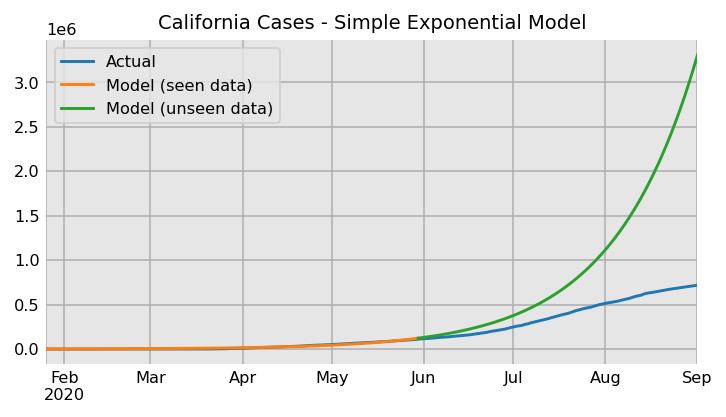

In [42]:
y = californiac[:'2020-05-30']
x = np.arange(len(y))
res = least_squares(optimize_func, p0, args=(x, y, simple_exp), bounds=bounds)
x_pred = np.arange(len(californiac))
y_pred = simple_exp(x_pred, *res.x)
s_pred = pd.Series(data=y_pred, index=californiac.index)
californiac.plot(label="Actual")
s_pred[:'2020-05-30'].plot(label="Model (seen data)", 
                        title="California Cases - Simple Exponential Model")
s_pred['2020-05-30':].plot(label="Model (unseen data)").legend();

The predicted values don't allign with the actual values.

### Optimizing `least_squares`

The purpose of the `least_squares` method is to find a set of parameters that minimizes the error between actual values and values predicted by the model. 

The `least_square` method calculates the optimal set of parameters through an algorithm that itertaivly calculates the sum of squared errors (SEE). In the case that the change in the SSE is below a predefined threshold the algorith will stop and return the parameters. There are two main thresholds for the `least_square` method.

* `ftol` - change in SSE (default 1e-8)
* `xtol` - change in parameter values (default 1e-8)

Useful parameters:

* `max_nfev` - Maximum number of function evaluations before algorithm stops (default: number of observations * 100)
* `verbose` - Set to 1 for printed results and 2 for detailed results (default: 0).


In [43]:
res = least_squares(optimize_func, p0, args=(x, y, simple_exp), bounds=bounds, verbose=1)
res.x

`ftol` termination condition is satisfied.
Function evaluations 50, initial cost 1.1324e+11, final cost 2.0323e+09, first-order optimality 3.30e+05.


array([1.53723531e+03, 1.03565909e+00])

In [44]:
def train_model(s, last_date, model, bounds, p0, **kwargs):
    """
    Trains a model on the series up to the specified date.

    Parameters
    ----------
    s : Series
    last_date : str
    model : function
    bounds : tuple
    p0 : tuple
    kwargs : dict

    Returns
    -------
    numpy array
    """
    y = s.loc[:last_date]
    n_train = len(y)
    x = np.arange(n_train)
    res = least_squares(optimize_func, p0, args=(x, y, model), bounds=bounds, **kwargs)
    return res.x

Previously, I tested the accuracy of my predictive model by comparing predicted values with actual values. I built the model up to May 30th. I will conduct the same test with my new model. 


In [45]:
from functions import train_model
last_date = '2020-05-30'
params = train_model(californiac, last_date=last_date,
                     model=simple_exp, p0=p0, bounds=bounds)
params

array([1.53723531e+03, 1.03565909e+00])

In [46]:
def get_daily_pred(model, params, n_train, n_pred):
    """
    Generates daily predictions using the trained model.

    Parameters
    ----------
    model : function
    params : array
    n_train : int
    n_pred : int

    Returns
    -------
    array
    """
    x_pred = np.arange(n_train - 1, n_train + n_pred)
    y_pred = model(x_pred, *params)
    y_pred_daily = np.diff(y_pred)
    return y_pred_daily

Using the `get_daily_pred` function to predict the next 50 daily new cases in California.

In [47]:
from functions import get_daily_pred
n_train = len(californiac.loc[:last_date])
y_pred_daily = get_daily_pred(simple_exp, params, n_train, n_pred=50).round()
y_pred_daily

array([ 4375.,  4531.,  4693.,  4860.,  5034.,  5213.,  5399.,  5592.,
        5791.,  5997.,  6211.,  6433.,  6662.,  6900.,  7146.,  7401.,
        7664.,  7938.,  8221.,  8514.,  8818.,  9132.,  9458.,  9795.,
       10144., 10506., 10881., 11269., 11670., 12087., 12518., 12964.,
       13426., 13905., 14401., 14914., 15446., 15997., 16567., 17158.,
       17770., 18404., 19060., 19740., 20443., 21172., 21927., 22709.,
       23519., 24358.])

These daily values can be used to calculate the total the cumulative total for California cases.

In [48]:
#Finding last known total
last_actual_value = californiac['2020-5-30']
last_actual_value

111532

Adding the value above (last_actual_value) can be used to find predicted cumulative total.

In [49]:
y_pred_cumulative = y_pred_daily.cumsum() + last_actual_value
y_pred_cumulative

array([115907., 120438., 125131., 129991., 135025., 140238., 145637.,
       151229., 157020., 163017., 169228., 175661., 182323., 189223.,
       196369., 203770., 211434., 219372., 227593., 236107., 244925.,
       254057., 263515., 273310., 283454., 293960., 304841., 316110.,
       327780., 339867., 352385., 365349., 378775., 392680., 407081.,
       421995., 437441., 453438., 470005., 487163., 504933., 523337.,
       542397., 562137., 582580., 603752., 625679., 648388., 671907.,
       696265.])

In [50]:
def get_cumulative_pred(last_actual_value, y_pred_daily, last_date):
    """
    Calculates cumulative predictions from daily forecasts.

    Parameters
    ----------
    last_actual_value : int
    y_pred_daily : array
    last_date : str

    Returns
    -------
    Series
    """
    first_pred_date = pd.Timestamp(last_date) + pd.Timedelta("1D")
    n_pred = len(y_pred_daily)
    index = pd.date_range(start=first_pred_date, periods=n_pred)
    return pd.Series(y_pred_daily.cumsum(), index=index) + last_actual_value



The predictive model used earlier did not provide acurate results (mismatch between predicted and actual values). By implimenting the predicted daily values for the cumulative total remedies the issue faced with when using the smoothed data with cumulative values that didn't allign with the last cumulative value.

In [51]:
from functions import get_cumulative_pred
s_pred_cumulative = get_cumulative_pred(last_actual_value, y_pred_daily, "2020-05-30")
s_pred_cumulative.tail()

2020-07-15    603752.0
2020-07-16    625679.0
2020-07-17    648388.0
2020-07-18    671907.0
2020-07-19    696265.0
Freq: D, dtype: float64

In [52]:
def plot_prediction(s, s_pred, title=""):
    """
    Plots original and predicted values.

    Parameters
    ----------
    s : Series
    s_pred : Series
    title : str

    Returns
    -------
    None
    """
    last_pred_date = s_pred.index[-1]
    ax = s[:last_pred_date].plot(label="Actual")
    s_pred.plot(label="Predicted")
    ax.legend()
    ax.set_title(title)

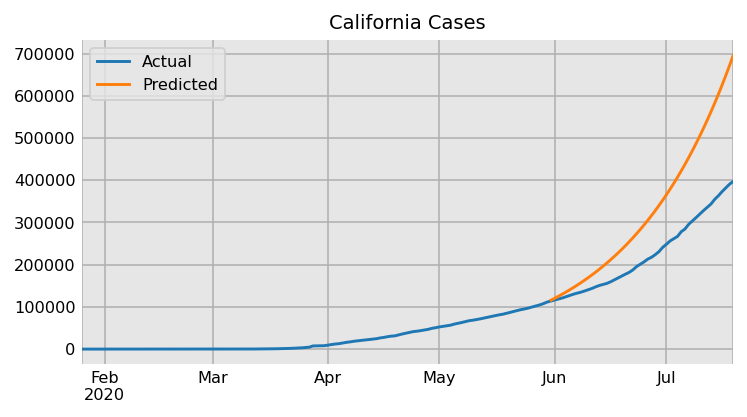

In [53]:
from functions import plot_prediction
plot_prediction(californiac, s_pred_cumulative, title="California Cases")

In [54]:
from functions import smooth

def predict_all(s, start_date, last_date, n_smooth, n_pred, model, bounds, p0, title="", **kwargs):
    """
    Full pipeline to smooth, train, predict, and plot a data series.

    Parameters
    ----------
    s : Series
    start_date, last_date : str
    n_smooth, n_pred : int
    model : function
    bounds, p0 : tuple
    title : str

    Returns
    -------
    tuple
    """
    # Smooth up to the last date
    s_smooth = smooth(s[:last_date], n=n_smooth)

    # Filter for the start of the modeling period
    s_smooth = s_smooth[start_date:]
    params = train_model(
        s_smooth, last_date=last_date, model=model, bounds=bounds, p0=p0, **kwargs
    )
    n_train = len(s_smooth)
    y_daily_pred = get_daily_pred(model, params, n_train, n_pred)
    last_actual_value = s.loc[last_date]
    s_cumulative_pred = get_cumulative_pred(last_actual_value, y_daily_pred, last_date)
    plot_prediction(s[start_date:], s_cumulative_pred, title=title)
    return params, y_daily_pred


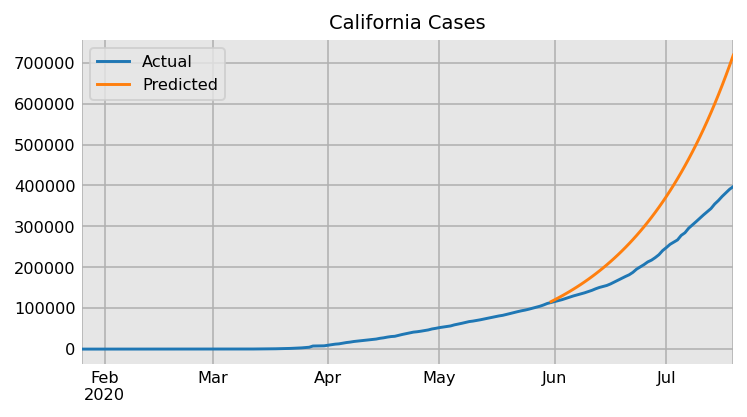

In [55]:
from functions import predict_all
bounds = (1, 1), (np.inf, 10)
p0 = 1, 1
params, y_pred = predict_all(californiac, start_date=None, last_date="2020-05-30", n_smooth=15, 
                             n_pred=50, model=simple_exp, bounds=bounds, 
                             p0=p0, title="California Cases")

### Continuous Growth with $e$


This COVID dataset contains information reported once per day. Continuous growth uses $e$ to represent the limit of the growth rate if the growth rate were measured in very small intervals. If this model applied continuous growth using $e$ as opposed to daily growth, the model would apply the following formula:

$$f(x) = a e^{bx}$$


`a` still represents the initial value and `b` still represent s the growth rate, however the growth rate can be negative or positive. 


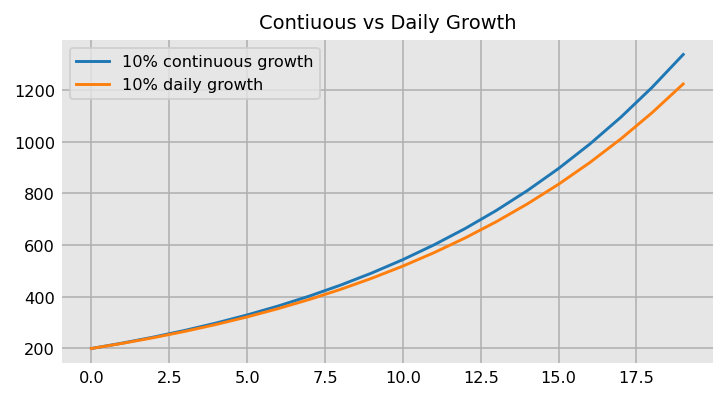

In [56]:
x = np.arange(20)
a = 200
b_old = 1.1
b_new = b_old - 1
y_old = a * b_old ** x
y_new = a * np.exp(b_new * x)

fig, ax = plt.subplots()
ax.set_title('Contiuous vs Daily Growth')
ax.plot(y_new, label='10% continuous growth')
ax.plot(y_old, label='10% daily growth')
ax.legend();

In [57]:
def simple_exp_cont(x, a, b):
    """
    Simple exponential model using continuous growth
    
    Parameters
    ----------
    x : array of x-values, usually just np.arange(len(y))
    
    a : initial starting value
    
    b : growth rate
    """
    return a * np.exp(b * x)

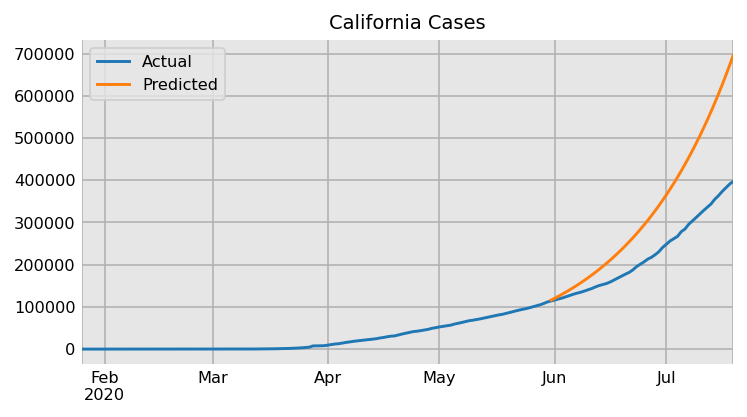

In [58]:
bounds = [1, 0.001], [10_000, 0.1]
p0 = 1, .01
predict_all(californiac,  start_date=None, last_date="2020-05-30", n_smooth=0.15, n_pred=50, 
            model=simple_exp_cont, bounds=bounds, p0=p0, title="California Cases");

## Modeling exponential decline

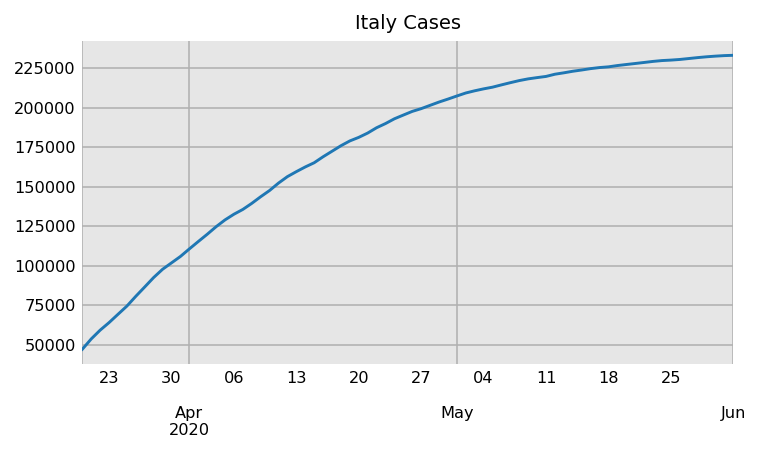

In [59]:
italyc = data['world_cases']['Italy']
italyc = italyc['2020-03-20':'2020-06-01']
italyc.plot(title="Italy Cases");

### Attempt to fit an exponential mode`
Testing the accuracy of the `predict_all` function. Fitting simple exponential model to Italy's April data. 

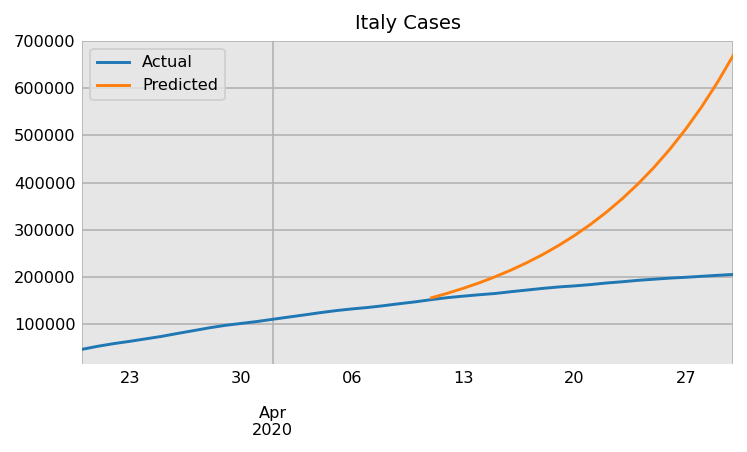

In [60]:
predict_all(italyc, start_date=None, last_date="2020-04-10", n_smooth=15, n_pred=20, 
            model=simple_exp_cont, bounds=bounds, p0=p0, title="Italy Cases");

### Increasing exponential decline


The continuous growth using e worked well for modeling the beginning during the period of exponential growth, but this approach did not accurately depict the slowdown. The actual values exponentially decline. Exponential decline occurs when values decline towards 0 but are declining toward an asymptote. This is **increasing exponential decline**. The values increase, but at slower rates over time. 


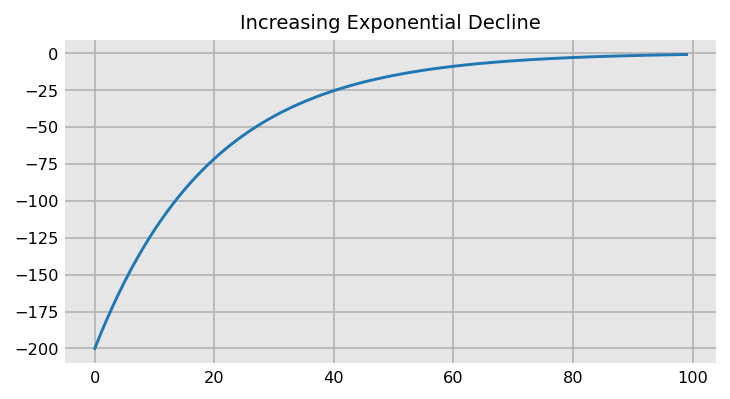

In [61]:
a = -200
b = .95
x = np.arange(100)
y = a * b ** x
fig, ax = plt.subplots()
ax.plot(y)
ax.set_title('Increasing Exponential Decline');

Variable `c` can be used to shift the values upwards.

$$f(x) = ab^x + c$$

or 


$$f(x) = ae^{bx} + c$$

Applying this model will movethe asymptote from 0 to `c` with the initial value now at `a + c`. In the case of increasing exponential decline `a` will always be negative and `b` will be less than 1. 


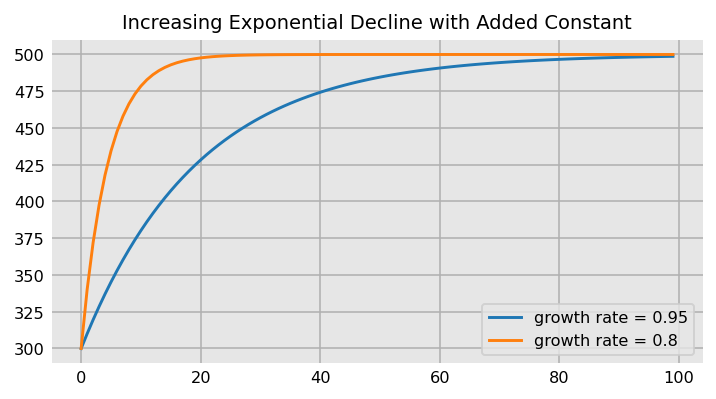

In [62]:
a = -200
b = 0.95
b2 = 0.8
c = 500
x = np.arange(100)
y = a * b ** x + c
y2 = a * b2 ** x + c

fig, ax = plt.subplots()
ax.plot(y, label=f'growth rate = {b}')
ax.plot(y2, label=f'growth rate = {b2}')
ax.set_title('Increasing Exponential Decline with Added Constant')
ax.legend();

Let's use this model for the currently selected cases in Italy using the following function to represent this new model.

In [63]:
def exp_decline(x, a, b, c):
    """
    Simple exponential decline model
    
    Parameters
    ----------
    x : array of x-values, usually just np.arange(len(y))
    
    a : initial value
    
    b : growth rate
    
    c : vertical shift
    """
    return a * b ** x + c

REWORD:

We must change our bounds in order for this model to work. Here, `a` must be negative, `b` between 0 and 1, and `c` positive. We set the bounds for both `a` and `c` to be a very wide interval as we do not know the final total of cases in Italy. Let's use the `predict_all` function to build a model using data up through April 10.

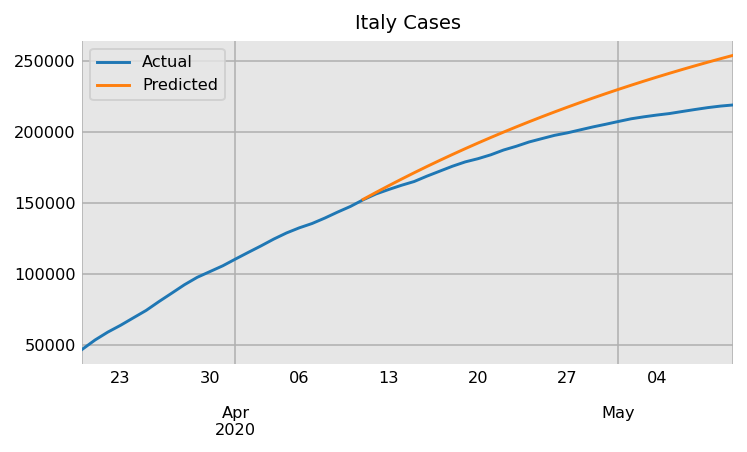

In [64]:
bounds = [-1000000, .1, 0], [-1, 1, np.inf]
p0 = -1000, .5, 100
predict_all(italyc, start_date=None, last_date="2020-04-10", n_smooth=15, n_pred=30, 
            model=exp_decline, bounds=bounds, p0=p0, title="Italy Cases");

REWORDThe shape of the model looks good and the predictions are decent. Below, we build the same model using continuous growth.

In [65]:
def exp_decline_cont(x, a, b, c):
    """
    Simple exponential decline with continuous growth
    
    Parameters
    ----------
    x : array of x-values, usually just np.arange(len(y))
    
    a : initial value
    
    b : growth rate
    
    c : vertical shift
    """
    return a * np.exp(b * x) + c

REWORD:The bounds for the growth rate must be set to be negative.

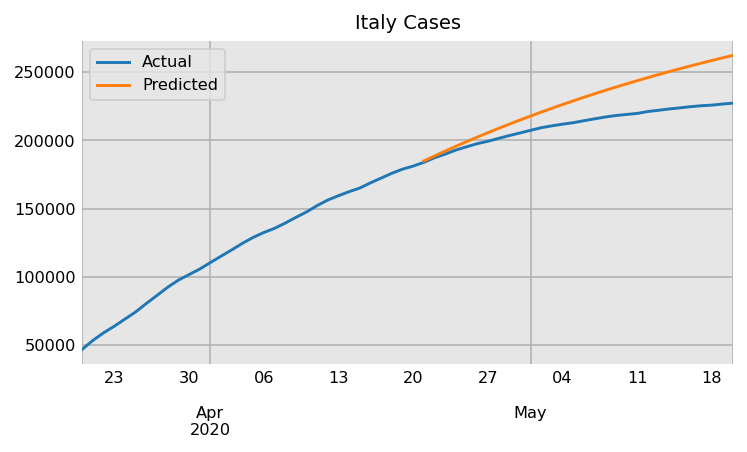

In [66]:
bounds = [-1000000, -1, 0], [-1, 0, np.inf]
p0 = -1, -1, 1
predict_all(italyc['2020-03-10':], start_date=None, last_date="2020-04-20", n_smooth=15, n_pred=30, 
            model=exp_decline_cont, bounds=bounds, p0=p0, title="Italy Cases");